# Adding year information to data
This notebook takes as input two files that are generated by scripts: 

|file|script|
|---|---|
|`all_lyrics_scraped_20180625-155423.csv`   |`lyrics_scraper.py`   |
|`lyrics_with_spotify.csv`   |`spotify_scraper.py`   |

These two dataframes are joined on name, and the year is extracted from each.

## 1\. Imports and functions

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import random

from TurkishStemmer import TurkishStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re

def remove_ads(text):
    pattern = r'(eval.*])'
    return re.sub(pattern, "", text)

def regularize_whitespace(text):
    whitepattern = r'\s+'
    return re.sub(whitepattern, " ", text)

def remove_and_reg(text):
    text = remove_ads(text)
    text = regularize_whitespace(text)
    return text

def check_for_english(text):
    text_words = text.split(" ")
    english_words = set(['I', "we're", "the", "an", "one", "to", "give", "love"])
    counter = 0
    for word in text_words:
        if word in english_words:
            counter += 1
    return counter

## 2\. Reading in data
- `spotify_df` is scraped from spotify, top hits, with a column for verification
- `main_df` is scraped from alternatifim, with names, artists  
***For more information, check the README and the scraping scripts***

In [97]:
spotify_df = pd.read_csv('../assets/lyrics/lyrics_with_spotify.csv', index_col=0)
main_df = pd.read_csv('../assets/lyrics/all_lyrics_scraped_20180625-155423.csv', index_col = 0)

In [98]:
main_df.shape

(55685, 4)

## 3\. Cleaning functions to main data

In [99]:
main_df['text'] = main_df['text'].map(remove_and_reg)
main_df['english_score'] = main_df['text'].map(check_for_english)

In [107]:
main_df[main_df['english_score'] != 0].loc[np.random.choice(main_df[main_df['english_score'] != 0].index),'text']

"(Karen Drotar - Bonnie Tyler&Serge Haouzi - John Stage) Na na na na na Na na na na na Na na na na na nana na na na na Na na na na na Na na na na na Na na na na na nana na na na na Let's celebrate and have a good time We got the power We can be one Let us celebrate, you know the party's begun Yes I can feel you Gettin' on down Just take these good vibes And spread them around Na na na na na Na na na na na Let's celebrate and have a good time Everybody laugh (celebrate) Everybody dance (good times, yeah) "

In [35]:
main_df = main_df[main_df['english_score'] == 0]

In [36]:
main_df.head(2)

,artist,title,album,text,english_score
89,A P O,"3 Büyükler (Ft. Yener, 9canlı)",galexsnake,9canlı Verse: Bana sordular sorular soruldu ce...,0
91,A P O,34 Kotak D,Compilation Vol. 1,Eypi Bana bi mermi ver bende kurşun var kurşun...,0


In [37]:
spotify_df.head(2)

,release,name,real_name
89,NaN,NaN,"3 Büyükler (Ft. Yener, 9canlı)"
91,NaN,NaN,34 Kotak D


## 4\. Joining the data together. They share an index, and the columns `real_data` and `title` should be exactly the same.

In [38]:
joined_df = pd.concat([main_df, spotify_df], axis=1)

## 5\. Getting rid of `NaN` rows and rows where the spotify name and real name aren't exactly the same
In the spotify data, whenever a song couldn't be found, the script put a NaN into that slot. THe first step is to just remove that. In the future, if I decide to try other sources for year data, some of these slots could be filled. Until then I'm not going to worry about it.
    
This might be overly conservative, and I might be missing data. My justification is that of course I'm missing 'data'. In the real world there are thousands of songs that aren't transcribed, thousands of dates that are unrecorded. I can try to do better, perhaps, but there is no such thing as "all the data" in this circumstance.

In [39]:
joined_df_no_nas = joined_df.dropna()

In [40]:
print(joined_df.shape)
print(joined_df_no_nas.shape)

(41943, 8)
(18665, 8)


In [41]:
mask = joined_df_no_nas['title'] == joined_df_no_nas['name']

In [42]:
mask.mean()

0.84066434503080634

In [43]:
joined_df_no_nas[mask].shape

(15691, 8)

In [44]:
joined_df_no_nas[mask].to_csv('../assets/lyrics/master_data_20180626.csv')

In [45]:
df = joined_df_no_nas[mask].copy()

In [46]:
times = pd.to_datetime(df['release'])

In [47]:
df.drop('real_name', axis = 1, inplace = True)

In [48]:
df.columns = ['artist_name', 'song_title', 'album_name', 'song_text', 'english_score', 'release_date', 'song_name']

In [49]:
df.drop('english_score', axis  =1, inplace=True)

In [50]:
df.head()

,artist_name,song_title,album_name,song_text,release_date,song_name
285,Abdal,Altın Yüzüğüm Kırıldı,Ervah-I Ezelde,Altın yüzüğüm kırıldı (hey) Suya düştü su duru...,2013-03-16,Altın Yüzüğüm Kırıldı
286,Abdal,Bağbozumu,Ervah-I Ezelde,Bir bağ bozumuydu gidişin Plajlar boşalmıştı B...,2011-12-02,Bağbozumu
289,Abdal,Bir Of Çeksem Karşıki Dağlar Yıkılır,Ervah-I Ezelde,Bir of çeksem karşı ki dağlar yıkılır Bugün po...,2011-12-02,Bir Of Çeksem Karşıki Dağlar Yıkılır
292,Abdal,Eğin Dedikleri Bir Küçük Şehir,Ervah-I Ezelde,Eğin dedikleri (anam) bir küçük şehir (nidem) ...,2011-12-02,Eğin Dedikleri Bir Küçük Şehir
296,Abdullah Akbulak,Acizim,Zakirin Gözyaşı,"Subhanım Allah, sultanım Allah, Mağrifet eden ...",2003-11-07,Acizim


In [51]:
df['release_date'] = pd.to_datetime(df['release_date'])

In [52]:
df['year'] = df['release_date'].dt.year

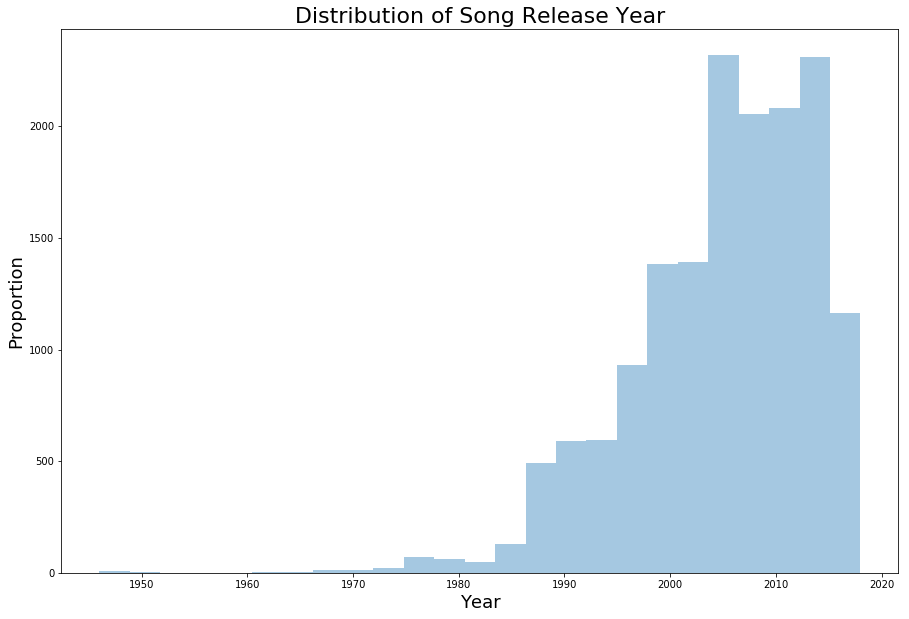

In [53]:
plt.figure(figsize = (15,10))
sns.distplot(df['year'], bins = 25, kde = False)
plt.title("Distribution of Song Release Year", fontsize = 22)
plt.xlabel("Year", fontsize = 18)
plt.ylabel("Proportion", fontsize = 18)
plt.savefig("../assets/visualizations/year_distribution.png")

In [54]:
df['year'].min()

1946

In [55]:
df[df['year'] == 1946]

,artist_name,song_title,album_name,song_text,release_date,song_name,year
26673,Hamiyet Yüceses,Kadifeden Kesesi,Her Yer Karanlık,Kadifeden kesesi Kahveden gelir sesi Oturmuş k...,1946-08-04,Kadifeden Kesesi,1946


In [95]:
df.loc[np.random.choice(df.index), 'song_text']

'Anılar seçer insanın yaralı sonunu Aradan geçen yılların demeye lafı yok Havadan sudan bahsedip günü oyaladık O kadar gecikti ki bu aşk seneye tadı yok Bu kapıdan iyisi de gönüllü geçiyor Hayat onu bile bile ölümlü seçiyor Hevesini kıra kıra bir lokma çocuğun Eline koz veriyor O da bunu bile bile yalancı çıkacak Doğanın özüne göre savaşçı olacak '